# Egyptian Ministry of Health Hotline Analysis
## Analyzing Citizen Complaints and Service Efficiency (2025)

---

### Project Overview

**Business Problem:**
The Egyptian Ministry of Health operates a national hotline serving millions of citizens with health-related complaints, inquiries, and emergency reports.
Understanding call patterns, response efficiency, and common issues is critical for improving citizen services and allocating resources effectively.

This analysis investigates:
- **What are citizens calling about?** (Top complaint types and trends)
- **How efficiently are we responding?** (Resolution times and bottlenecks)
- **Where is demand highest?** (Geographic distribution of calls)
- **How can we improve service delivery?** (Data-driven recommendations)

---

### Dataset

- **Source:** Ministry of Health Hotline System (Internal Database)
- **Time Period:** January 2025 - January 2026 (13 months)
- **Records:** ~48,000 citizen calls
- **Geographic Coverage:** Multiple Egyptian governorates
- **Data Type:** Operational hotline data (anonymized)

**Key Variables:**
- Timestamp (date/time of call)
- Complaint subject and entity
- Complaint status (open/closed)
- Employee handling the call
- Geographic location (governorate)
- Call details and follow-up notes

**Data Privacy:**
All personally identifiable information (caller names, phone numbers) has
been anonymized using cryptographic hashing to protect citizen privacy while
maintaining analytical integrity.

---

### Analysis Objectives

1. **Volume & Trend Analysis**
   - Identify call volume patterns (daily, weekly, monthly)
   - Detect seasonal trends and peak demand periods
   - Forecast future call volumes

2. **Complaint Classification**
   - Categorize complaint types and their frequency
   - Identify top 10 most common citizen issues
   - Analyze complaint distribution by entity/department

3. **Operational Efficiency**
   - Calculate average resolution time
   - Identify bottlenecks in complaint handling
   - Compare employee/team performance

4. **Geographic Analysis**
   - Map complaint distribution across governorates
   - Identify underserved or high-demand regions
   - Analyze regional differences in complaint types

5. **Recommendations**
   - Propose staffing adjustments based on demand patterns
   - Suggest process improvements for faster resolution
   - Recommend targeted interventions for top complaint types

---

### Tools & Methodology

**Technologies:**
- **Python 3.9+** - Primary analysis language
- **Pandas & NumPy** - Data manipulation and analysis
- **Matplotlib & Seaborn** - Statistical visualizations
- **Plotly** - Interactive dashboards
- **SciPy** - Statistical testing

**Analytical Approach:**
- Exploratory Data Analysis (EDA)
- Time series analysis
- Descriptive statistics
- Hypothesis testing (ANOVA)
- Trend forecasting

---

### 👤 About This Analysis

**Analyst:** Ahmed Abdelmoneim El-Shahat
**Role:** Data Analyst & Hotline Supervisor | Ministry of Health
**Background:** Pharmacist with 4+ years healthcare operations experience
**Contact:** ahmed.elshahat.eru2016@gmail.com | [LinkedIn](https://linkedin.com/in/ahmed-shahat) | [GitHub](https://github.com/A-Shahat)

**Context:**
This analysis was conducted as part of ongoing efforts to improve citizen services and operational efficiency within the Ministry of Health's hotline operations. Findings will inform resource allocation, staffing decisions, and process improvements.

---

### Table of Contents

1. Data Loading & Initial Exploration
2. Data Quality Assessment
3. Exploratory Data Analysis
   - 3.1 Volume & Trends
   - 3.2 Complaint Classification
   - 3.3 Geographic Distribution
4. Operational Efficiency Analysis
5. Statistical Testing
6. Key Findings & Insights
7. Recommendations
8. Conclusions

---

**Let's begin the analysis.**

In [1]:
import warnings

from matplotlib.pyplot import xticks

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import f_oneway

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

PLOTLY_TEMPLATE = 'plotly_white'

COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'success': '#06A77D',
    'warning': '#F77F00',
    'danger': '#D62828',
    'info': '#6A4C93'
}

### Dataset Structure

Below is the complete structure of our hotline dataset after cleaning and translation.

In [2]:
df=pd.read_excel('ministry_hotline_processed.xlsx')
df['timestamp'] = pd.to_datetime(df['timestamp'],errors='coerce')
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['month_name'] = df['timestamp'].dt.month_name()
df['day'] = df['timestamp'].dt.day
df['hour']  = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()
df['day_of_week_num'] = df['timestamp'].dt.dayofweek
df['week'] = df['timestamp'].dt.isocalendar().week.astype(int)
df['quarter'] = df['timestamp'].dt.quarter
df['is_weekend'] = df['day_of_week_num'].isin([4, 5])
df['day_type'] = df['is_weekend'].map({True: 'Weekend', False: 'Weekday'})
df['time_of_day']     = pd.cut(
    df['hour'],
    bins=[0, 6, 12, 18, 24],
    labels=['Night (12AM-6AM)', 'Morning (6AM-12PM)','Afternoon (12PM-6PM)', 'Evening (6PM-12AM)'],include_lowest=True)

df.set_index('timestamp', inplace=True)

df.sample(5)

,caller_id,phone_id,complaint_subject,complaint_entity,complaint_status,employee,email,call_details,is_emergency,hospital_type,complaint_subject_en,complaint_entity_en,complaint_status_en,employee_en,email_en,is_emergency_en,hospital_type_en,year,month,month_name,day,hour,day_of_week,day_of_week_num,week,quarter,is_weekend,day_type,time_of_day
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-05-29 09:22:31.977,CALLER_5C0730FF,CALLER_860CE8EF,طوارئ (دم - رعاية - حضانة),الرعاية الحرجة,تم الرد,اسماء جمال السيد,asmaagemy12345@icloud.com,NaN,NaN,NaN,Emergency (blood - care - nursery),Critical care,Answered,The names of Jamal Al-Sayed,asmaagemy12345@icloud.com,NaN,NaN,2025,5,May,29,9,Thursday,3,22,2,False,Weekday,Morning (6AM-12PM)
2025-01-30 00:00:00.000,CALLER_1F940D08,CALLER_7904759B,استفسارات,الغربية,تم الرد,محمد جمال عبدالحافظ,NaN,NaN,المديريات,علاج,inquiries,Western,Answered,Muhammad Gamal Abdel Hafez,NaN,Directorates,treatment,2025,1,January,30,0,Thursday,3,5,1,False,Weekday,Night (12AM-6AM)
2025-01-30 00:00:00.000,CALLER_1F940D08,CALLER_7904759B,لقاحات وامصال,القاهرة,تم الرد,عمر خالد فاضل,NaN,NaN,المديريات,تطعيمات ولقاحات,Vaccines and serums,Cairo,Answered,Omar Khaled Fadel,NaN,Directorates,Vaccinations and vaccinations,2025,1,January,30,0,Thursday,3,5,1,False,Weekday,Night (12AM-6AM)
2025-09-20 14:19:36.395,CALLER_E056FC16,CALLER_D22A509E,كارت خدمات متكاملة,المجالس الطبية,تم الرد,كريم سامى محمد الزيات,karimelzayat.1997@gmail.com,فاتو ميعاد كشف كارت الخدمات المتكاملة وتم افاد...,لا,NaN,Integrated services card,Medical councils,Answered,Karim Sami Muhammad Al-Zayat,karimelzayat.1997@gmail.com,no,NaN,2025,9,September,20,14,Saturday,5,38,3,True,Weekend,Afternoon (12PM-6PM)
2025-10-26 13:10:48.097,CALLER_1FCB9D95,CALLER_E1943B7F,علاج,المجالس الطبية,تم الرد,عمر خالد فاضل,omarkhaledfadel@gmail.com,استفسار عن اجراءت العلاج على نفقة الدولة,لا,NaN,treatment,Medical councils,Answered,Omar Khaled Fadel,omarkhaledfadel@gmail.com,no,NaN,2025,10,October,26,13,Sunday,6,43,4,False,Weekday,Afternoon (12PM-6PM)


In [3]:
def info(x):
    print('Number of elements in the dataframe:', x.size)
    print('Number of rows in the dataframe:', x.shape[0])
    print('Number of columns in the dataframe:', x.shape[1])
    print('Number of unique values in the dataframe:', x.nunique())
    print('Number of null values in the dataframe:', x.isnull().sum())
    print('PCT of null values in the dataframe:', (x.isnull().sum()/x.size)*100)

info(df)

Number of elements in the dataframe: 1397104
Number of rows in the dataframe: 48176
Number of columns in the dataframe: 29
Number of unique values in the dataframe: caller_id               30141
phone_id                36822
complaint_subject          25
complaint_entity           44
complaint_status            2
employee                   32
email                      25
call_details            13754
is_emergency                8
hospital_type              14
complaint_subject_en       24
complaint_entity_en        43
complaint_status_en         2
employee_en                32
email_en                   25
is_emergency_en             8
hospital_type_en           14
year                        3
month                      12
month_name                 12
day                        31
hour                       24
day_of_week                 7
day_of_week_num             7
week                       47
quarter                     4
is_weekend                  2
day_type                 

In [4]:
working_data=df.copy()

In [5]:
working_data.drop(['complaint_subject','complaint_entity','complaint_status','employee','email','call_details','is_emergency','hospital_type','is_emergency_en','hospital_type_en','email_en'],axis=1,inplace=True)

In [6]:
working_data.head(10)

,caller_id,phone_id,complaint_subject_en,complaint_entity_en,complaint_status_en,employee_en,year,month,month_name,day,hour,day_of_week,day_of_week_num,week,quarter,is_weekend,day_type,time_of_day
timestamp,,,,,,,,,,,,,,,,,,
2024-12-30,CALLER_1F940D08,CALLER_7904759B,Death certificate,Cairo,Answered,Sherine Naeem Hafez,2024,12,December,30,0,Monday,0,1,4,False,Weekday,Night (12AM-6AM)
2024-12-30,CALLER_1F940D08,CALLER_7904759B,Emergency (blood - care - nursery),Critical care,Answered,Sherine Naeem Hafez,2024,12,December,30,0,Monday,0,1,4,False,Weekday,Night (12AM-6AM)
2024-12-30,CALLER_1F940D08,CALLER_7904759B,Lack of jurisdiction,Lack of jurisdiction,Answered,Sherine Naeem Hafez,2024,12,December,30,0,Monday,0,1,4,False,Weekday,Night (12AM-6AM)
2024-12-30,CALLER_1F940D08,CALLER_7904759B,Vaccines and serums,Serum and vaccine,Answered,Sherine Naeem Hafez,2024,12,December,30,0,Monday,0,1,4,False,Weekday,Night (12AM-6AM)
2024-12-30,CALLER_1F940D08,CALLER_7904759B,treatment,Medical councils,Answered,Sherine Naeem Hafez,2024,12,December,30,0,Monday,0,1,4,False,Weekday,Night (12AM-6AM)
2024-12-30,CALLER_1F940D08,CALLER_7904759B,treatment,Waiting lists,Answered,Sherine Naeem Hafez,2024,12,December,30,0,Monday,0,1,4,False,Weekday,Night (12AM-6AM)
2024-12-30,CALLER_1F940D08,CALLER_7904759B,Vaccines and serums,Cairo,Answered,Sherine Naeem Hafez,2024,12,December,30,0,Monday,0,1,4,False,Weekday,Night (12AM-6AM)
2024-12-30,CALLER_1F940D08,CALLER_7904759B,Lack of jurisdiction,Lack of jurisdiction,Answered,Sherine Naeem Hafez,2024,12,December,30,0,Monday,0,1,4,False,Weekday,Night (12AM-6AM)
2024-12-30,CALLER_1F940D08,CALLER_7904759B,Dairy,Assiut,Answered,Sherine Naeem Hafez,2024,12,December,30,0,Monday,0,1,4,False,Weekday,Night (12AM-6AM)


In [7]:
working_data['complaint_entity_en'] = (
    working_data['complaint_entity_en']
    .replace({
        'lack of jurisdiction': 'Incompetence',
        'Eastern': 'Sharqia',
        'The Lake': 'Behira',
        'western': 'Gharbia'}))

df['employee_en'] = (
    df['employee_en']
    .astype(str)
    .str.replace('The names of', 'Asmaa', regex=False))

In [8]:
info(working_data)

Number of elements in the dataframe: 867168
Number of rows in the dataframe: 48176
Number of columns in the dataframe: 18
Number of unique values in the dataframe: caller_id               30141
phone_id                36822
complaint_subject_en       24
complaint_entity_en        43
complaint_status_en         2
employee_en                32
year                        3
month                      12
month_name                 12
day                        31
hour                       24
day_of_week                 7
day_of_week_num             7
week                       47
quarter                     4
is_weekend                  2
day_type                    2
time_of_day                 4
dtype: int64
Number of null values in the dataframe: caller_id                0
phone_id                 0
complaint_subject_en    65
complaint_entity_en     65
complaint_status_en     17
employee_en              0
year                     0
month                    0
month_name               0


## 2. Data Quality Assessment

Before diving into analysis, we must validate data quality and understand any limitations or issues that could affect our conclusions.

In [9]:
print('\n[1] MISSING VALUES ANALYSIS')

missing_stats = pd.DataFrame({
    'Column': working_data.columns,
    'Missing Count': working_data.isnull().sum().values,
    'Missing %': (working_data.isnull().sum() / len(working_data) * 100).values})

missing_stats = missing_stats[missing_stats['Missing Count'] > 0].sort_values('Missing %', ascending=False)

if len(missing_stats) > 0:
    print(f'\nColumns with missing values: {len(missing_stats)}')
    print(missing_stats.to_string(index=False))
else:
    print('\n No missing values detected')


print('\n\n[2] DUPLICATE RECORDS CHECK')

duplicates = working_data.duplicated().sum()
print(f'Total duplicate rows: {duplicates:,}')

if duplicates > 0:
    print(f'Warning: {duplicates:,} duplicate records found')
    print("Won't be removed due to the nature of the dataset")
else:
    print('No duplicate records')

print("\n\n[3] TEMPORAL COVERAGE")
start = working_data.index.min()
end = working_data.index.max()
days = (end - start).days + 1

print(f'Earliest call: {start}')
print(f'Latest call: {end}')
print(f'Total days covered: {days}')
print(f'Calls per day (average): {len(working_data) / days:.1f}')


print('\n\n[4] CATEGORICAL VARIABLES')

categorical_cols = working_data.select_dtypes(include='object').columns

for col in categorical_cols[:5]:
    unique_count = working_data[col].nunique()
    print(f'\n{col}:')
    print(f'  Unique values: {unique_count}')
    if unique_count <= 10:
        value_counts = working_data[col].value_counts()
        print('  Distribution:')
        for val, count in value_counts.items():
            pct = (count / len(working_data)) * 100
            print(f'    - {val}: {count:,} ({pct:.1f}%)')


[1] MISSING VALUES ANALYSIS

Columns with missing values: 3
              Column  Missing Count  Missing %
complaint_subject_en             65       0.13
 complaint_entity_en             65       0.13
 complaint_status_en             17       0.04


[2] DUPLICATE RECORDS CHECK
Total duplicate rows: 3,509
Won't be removed due to the nature of the dataset


[3] TEMPORAL COVERAGE
Earliest call: 2024-12-30 00:00:00
Latest call: 2026-02-02 13:45:16
Total days covered: 400
Calls per day (average): 120.4


[4] CATEGORICAL VARIABLES

caller_id:
  Unique values: 30141

phone_id:
  Unique values: 36822

complaint_subject_en:
  Unique values: 24

complaint_entity_en:
  Unique values: 43

complaint_status_en:
  Unique values: 2
  Distribution:
    - Answered: 48,157 (100.0%)
    - Following up: 2 (0.0%)


---

## 3. Exploratory Data Analysis

Now that we've validated data quality, let's explore patterns, trends, and insights within the hotline data.

---

### 3.1 Call Volume & Temporal Patterns

**Business Questions:**
- How many calls does the hotline receive daily/weekly/monthly?
- Are there specific days or times with peak call volume?
- Is call volume growing, stable, or declining over time?
- Can we identify seasonal patterns?

**Hypothesis:**
We expect higher call volumes during:
- Business hours (9 AM - 5 PM)
- Weekdays vs weekends
- Certain months (flu season, summer heat emergencies)

In [10]:
hourly = (
working_data.groupby('hour')
.size()
.reset_index(name='call_count'))

fig = px.line(
hourly,
x='hour',
y='call_count',
markers=True,
title= 'Hourly Call Volume Pattern',
labels={'hour': 'Hour of Day', 'call_count': 'Number of Calls'},
color_discrete_sequence=[COLORS['secondary']])

fig.update_layout(
template=PLOTLY_TEMPLATE,
xaxis=dict(tickvals=list(range(24)),
ticktext=[f"{h:02d}:00" for h in range(24)]))
fig.update_traces(line_width=3, marker_size=8)
fig.show()

peak_hour = hourly.loc[hourly['call_count'].idxmax()]
print(f'\n Peak Hour: {int(peak_hour['hour']):02d}:00 → {int(peak_hour['call_count']):,} calls')


 Peak Hour: 00:00 → 6,205 calls


In [11]:
df_2025 = working_data[working_data.index.year == 2025]

monthly = (
    df_2025
    .groupby(df_2025.index.to_period('M'))
    .size()
    .reset_index(name='call_count'))

monthly['month_label'] = monthly['timestamp'].astype(str)

fig = px.bar(
monthly,
x='month_label',
y='call_count',
text='call_count',
title='Monthly Call Volume',
labels={'month_label': 'Month', 'call_count': 'Number of Calls'},
color_discrete_sequence=[COLORS['primary']])

avg_calls = monthly['call_count'].mean()

fig.add_hline(y=avg_calls,line_dash='dash',annotation_text=f'Avg: {avg_calls:.0f}',annotation_position='top right')

fig.update_layout(
template=PLOTLY_TEMPLATE,
xaxis=dict(categoryorder='array',
categoryarray=['Jan','Feb','Mar','Apr','May','Jun',
'Jul','Aug','Sep','Oct','Nov','Dec']),
showlegend=False)

fig.update_traces(textposition='outside')
fig.show()

print('\n Monthly Summary')
print(f'  Busiest month  : {monthly.loc[monthly['call_count'].idxmax(), 'month_label']} '
f'({monthly['call_count'].max():,} calls)')
print(f'  Quietest month : {monthly.loc[monthly['call_count'].idxmin(), 'month_label']} '
f'({monthly['call_count'].min():,} calls)')
print(f'  Monthly average: {monthly['call_count'].mean():,.0f} calls')


 Monthly Summary
  Busiest month  : 2025-12 (5,331 calls)
  Quietest month : 2025-02 (1,418 calls)
  Monthly average: 3,483 calls


In [12]:
day_order = ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

dow = (
working_data.groupby('day_of_week')
.size()
.reset_index(name='call_count'))

dow['day_of_week'] = pd.Categorical(dow['day_of_week'], categories=day_order, ordered=True)
dow = dow.sort_values('day_of_week')

fig = px.bar(
dow,
x='day_of_week',
y='call_count',
text='call_count',
title='Calls by Day of Week',
labels={'day_of_week': 'Day', 'call_count': 'Number of Calls'},
color_discrete_sequence=[COLORS['secondary']])

fig.update_layout(template=PLOTLY_TEMPLATE, showlegend=False)
fig.update_traces(textposition='outside')
fig.show()

In [13]:
heatmap_data = (
df.groupby(['hour', 'day_of_week'])
.size()
.unstack(fill_value=0))

heatmap_data = heatmap_data[day_order]
heatmap_data = heatmap_data.reindex(range(24))
heatmap_data.index = [f"{h:02d}:00" for h in range(24)]

fig = px.imshow(
heatmap_data,
text_auto=True,
color_continuous_scale='Blues',
title='Call Volume Heatmap (Hour × Day of Week)',
labels=dict(x='Day of Week', y='Hour', color='Calls'))
fig.update_layout(template=PLOTLY_TEMPLATE, height=700)
fig.show()

### 3.2 Complaint Classification
   - Categorize complaint types and their frequency
   - Identify top 10 most common citizen issues
   - Analyze complaint distribution by entity/department

In [14]:
subjects = (
df['complaint_subject_en']
.value_counts()
.reset_index()
.rename(columns={'count': 'call_count'}))
subjects['percentage'] = (subjects['call_count'] / len(working_data) * 100).round(1)

fig = px.bar(
subjects,
x='call_count',
y='complaint_subject_en',
orientation='h',
text='percentage',
title='Complaint Subjects — Top Categories',
labels={'complaint_subject_en': 'Complaint Subject',
'call_count': 'Number of Calls'},
color_discrete_sequence=[COLORS['primary']])

fig.update_layout(template=PLOTLY_TEMPLATE, showlegend=False,
yaxis=dict(categoryorder='total ascending'))
fig.update_traces(texttemplate='%{text}%', textposition='outside')
fig.show()

print("\n Complaint Subject Summary")

for _, row in subjects.head(5).iterrows():
  print(f"  {row['complaint_subject_en']:35s} {int(row['call_count']):>6,}  ({row['percentage']}%)")


 Complaint Subject Summary
  Lack of jurisdiction                 8,454  (17.5%)
  treatment                            8,353  (17.3%)
  inquiries                            7,440  (15.4%)
  Complaints                           5,249  (10.9%)
  Vaccines and serums                  3,793  (7.9%)


In [15]:
entities = (
df['complaint_entity_en']
.value_counts()
.reset_index()
.rename(columns={'count': 'call_count'}))

entities['percentage'] = (entities['call_count'] / len(working_data) * 100).round(1)

fig = px.bar(
entities.head(15),
x='call_count',
y='complaint_entity_en',
orientation='h',
text='percentage',
title='Top 15 Complaint Entities (Departments)',
labels={'complaint_entity_en': 'Entity',
'call_count': 'Number of Calls'},
color_discrete_sequence=[COLORS['secondary']])

fig.update_layout(template=PLOTLY_TEMPLATE, showlegend=False,
yaxis=dict(categoryorder='total ascending'))
fig.update_traces(texttemplate='%{text}%', textposition='outside')
fig.show()

print("\n Complaint Entities Summary")

for _, row in entities.head(5).iterrows():
  print(f"  {row['complaint_entity_en']:35s} {int(row['call_count']):>6,}  ({row['percentage']}%)")


 Complaint Entities Summary
  Cairo                                8,809  (18.3%)
  Lack of jurisdiction                 8,615  (17.9%)
  Medical councils                     6,193  (12.9%)
  Giza                                 3,982  (8.3%)
  Cabinet complaints                   3,576  (7.4%)


## Employee Performance Analysis
### Questions:

* Which employees handle the most calls?
* Is workload distributed fairly?
* Is there a correlation between employee and complaint status?

In [16]:
employees = (
df['employee_en']
.value_counts()
.nlargest(18)
.sort_values(ascending=True)
.reset_index()
.rename(columns={'count': 'call_count'}))

employees = employees[employees['employee_en'].notna()]
employees['percentage'] = (employees['call_count'] / len(working_data) * 100).round(1)

fig = px.bar(
employees,
x='call_count',
y='employee_en',
title='Employee Workload Distribution',
orientation='h',
labels={'employee_en': 'Employee', 'call_count': 'Calls Handled'},
color_discrete_sequence=[COLORS['info']])

avg_calls_per_employee = (employees['call_count'].mean())
fig.add_vline(x=avg_calls_per_employee,line_dash='dash',annotation_text=f'Avg: {avg_calls_per_employee:.0f}',annotation_position='top right')

fig.update_layout(
template=PLOTLY_TEMPLATE,
showlegend=False,
xaxis_tickangle=-45)

fig.update_traces(textposition='outside')
fig.show()

print('\n Workload Summary')

print(f'  Total employees      : {len(employees)}')
print(f'  Average calls/employee: {employees['call_count'].mean():,.0f}')
print(f'  Max calls  : {employees['call_count'].max():,}')
print(f'  Min calls (lightest) : {employees['call_count'].min():,}')
print(f'  Std deviation        : {employees['call_count'].std():,.0f}')


 Workload Summary
  Total employees      : 18
  Average calls/employee: 2,379
  Max calls  : 3,183
  Min calls (lightest) : 1,676
  Std deviation        : 499


## Statistical Testing
### Purpose:
* Validate whether observed patterns are statistically significant — or could simply be due to random chance.
* Tests:

** ANOVA: Does call volume significantly differ across months?

In [17]:
print('\n\n Test : Monthly Call Volume — ANOVA')

print('  H₀: Average daily call volume is equal across all months')
print('  H₁: At least one month has a different mean\n')

working_2025 = working_data[working_data.index.year == 2025]

daily_calls = (
    working_2025
    .groupby(working_2025.index.date)
    .size()
    .reset_index(name='calls_per_day'))

daily_calls['date'] = pd.to_datetime(daily_calls['index'])
daily_calls['month'] = daily_calls['date'].dt.month

month_groups = [
    grp['calls_per_day'].values
    for _, grp in daily_calls.groupby('month')]

alpha=.05
f_stat, p_val_anova = f_oneway(*month_groups)
print(f'  F-Statistic : {f_stat:.4f}')
print(f'  P-Value     : {p_val_anova:.6f}')
if p_val_anova < alpha:
 print(f' REJECT H₀ (p < {alpha})')
 print('  → Daily call volume differs significantly across months.')

else:
 print(f'\n  FAIL to reject H₀ (p ≥ {alpha})')
 print('  → No significant difference in monthly call volumes.')



 Test : Monthly Call Volume — ANOVA
  H₀: Average daily call volume is equal across all months
  H₁: At least one month has a different mean

  F-Statistic : 297.1093
  P-Value     : 0.000000
 REJECT H₀ (p < 0.05)
  → Daily call volume differs significantly across months.


## Monte Carlo Simulation — Future Call Volume Forecasting
### Purpose:
* Use Monte Carlo simulation to forecast hotline call volumes for the upcoming months. Monte Carlo runs thousands of random simulations based on historical patterns (mean + variance) to produce a probability distribution of future outcomes — not just a single prediction.

### What We Simulate:

* Monthly call volume for the next 6 months
* Per-employee call volume for the next 6 months

  MONTE CARLO SIMULATION — MONTHLY CALL VOLUME

  Historical Mean  : 3,483 calls/month
  Historical Std   : 1,626
  Simulations      : 10,000
  Forecast Months  : 6


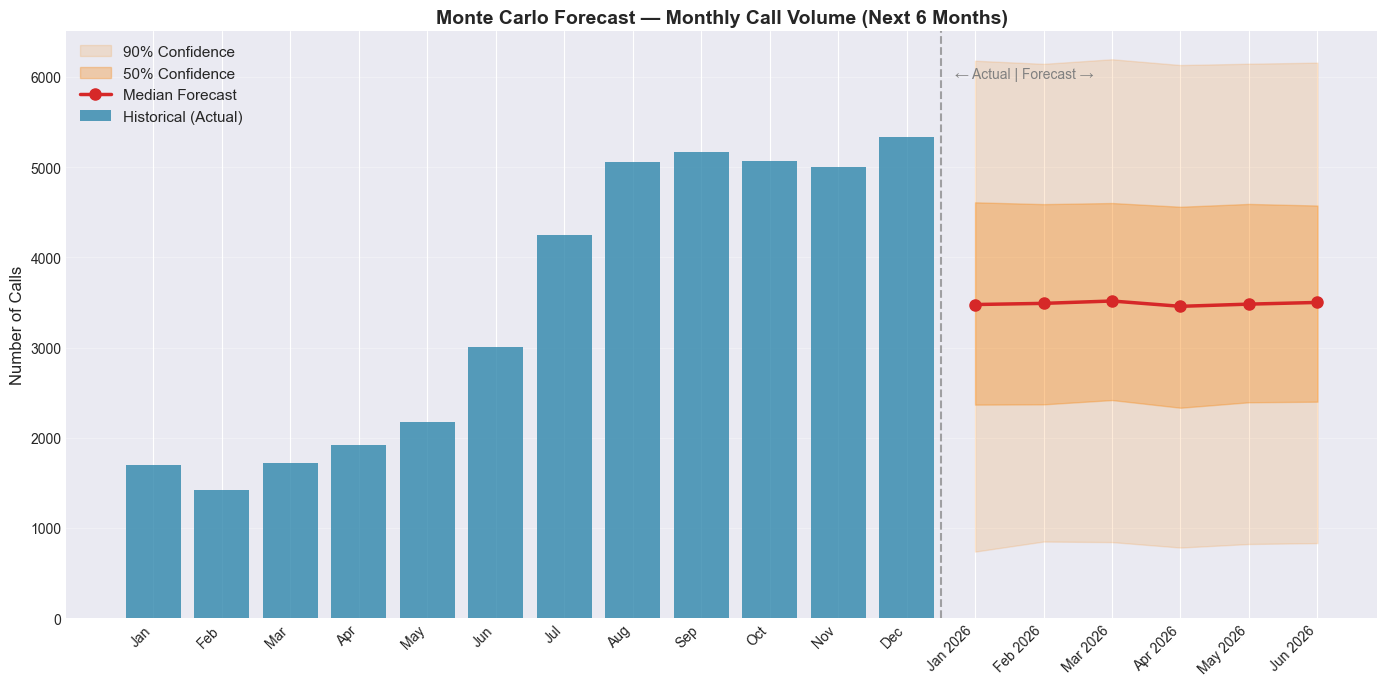


  Forecast Summary
  Month           5th %   25th %   Median   75th %   95th %
  Jan 2026          737    2,367    3,477    4,610    6,180
  Feb 2026          849    2,370    3,489    4,590    6,145
  Mar 2026          843    2,417    3,516    4,602    6,196
  Apr 2026          782    2,332    3,457    4,560    6,132
  May 2026          821    2,393    3,481    4,592    6,146
  Jun 2026          832    2,399    3,500    4,574    6,158


In [18]:
np.random.seed(42)
N_SIMULATIONS = 10_000
N_FORECAST_MONTHS = 6

data_2025=working_data[working_data.index.year == 2025]

hist_monthly = (
data_2025.groupby('month')
.size()
.reset_index(name='calls'))

hist_mean = hist_monthly['calls'].mean()
hist_std  = hist_monthly['calls'].std()

print('  MONTE CARLO SIMULATION — MONTHLY CALL VOLUME')

print(f'\n  Historical Mean  : {hist_mean:,.0f} calls/month')
print(f'  Historical Std   : {hist_std:,.0f}')
print(f'  Simulations      : {N_SIMULATIONS:,}')
print(f'  Forecast Months  : {N_FORECAST_MONTHS}')

simulations = np.random.normal(
loc=hist_mean,
scale=hist_std,
size=(N_SIMULATIONS, N_FORECAST_MONTHS))

simulations = np.clip(simulations, 0, None)

p5   = np.percentile(simulations, 5,  axis=0)
p25  = np.percentile(simulations, 25, axis=0)
p50  = np.percentile(simulations, 50, axis=0)
p75  = np.percentile(simulations, 75, axis=0)
p95  = np.percentile(simulations, 95, axis=0)

last_month = data_2025.index.max().month
last_year  = data_2025.index.max().year

forecast_labels = []
month_names = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',
7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
for i in range(1, N_FORECAST_MONTHS + 1):
  m = (last_month + i - 1) % 12 + 1
  y = last_year + (last_month + i - 1) // 12
  forecast_labels.append(f"{month_names[m]} {y}")

fig, ax = plt.subplots(figsize=(14, 7))

hist_labels = ['Jan','Feb','Mar','Apr','May','Jun',
'Jul','Aug','Sep','Oct','Nov','Dec']
hist_x = np.arange(len(hist_labels))
ax.bar(hist_x, hist_monthly['calls'], color=COLORS['primary'],
alpha=0.8, label='Historical (Actual)', zorder=3)

fore_x = np.arange(len(hist_labels), len(hist_labels) + N_FORECAST_MONTHS)

ax.fill_between(fore_x, p5,  p95, color=COLORS['warning'], alpha=0.15, label='90% Confidence')
ax.fill_between(fore_x, p25, p75, color=COLORS['warning'], alpha=0.30, label='50% Confidence')

ax.plot(fore_x, p50, color=COLORS['danger'], marker='o',
linewidth=2.5, markersize=8, label='Median Forecast', zorder=4)

ax.axvline(x=len(hist_labels) - 0.5, color='gray', linestyle='--',
linewidth=1.5, alpha=0.7)
ax.text(len(hist_labels) - 0.3, ax.get_ylim()[1] * 0.92,
'← Actual | Forecast →', fontsize=10, color='gray')

all_labels = hist_labels + forecast_labels
ax.set_xticks(range(len(all_labels)))
ax.set_xticklabels(all_labels, rotation=45, ha='right')
ax.set_ylabel('Number of Calls', fontsize=12)
ax.set_title('Monte Carlo Forecast — Monthly Call Volume (Next 6 Months)',
fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print('\n  Forecast Summary')
print(f'  {'Month':<12} {'5th %':>8} {'25th %':>8} {'Median':>8} {'75th %':>8} {'95th %':>8}')

for i in range(N_FORECAST_MONTHS):
  print(f"  {forecast_labels[i]:<12} {p5[i]:>8,.0f} {p25[i]:>8,.0f} {p50[i]:>8,.0f} {p75[i]:>8,.0f} {p95[i]:>8,.0f}")

## Monte Carlo — Per-Employee Forecast
* Now we repeat the same simulation per employee, so we can forecast individual workloads and plan staffing more precisely.

Simulated 18 employees for 2025


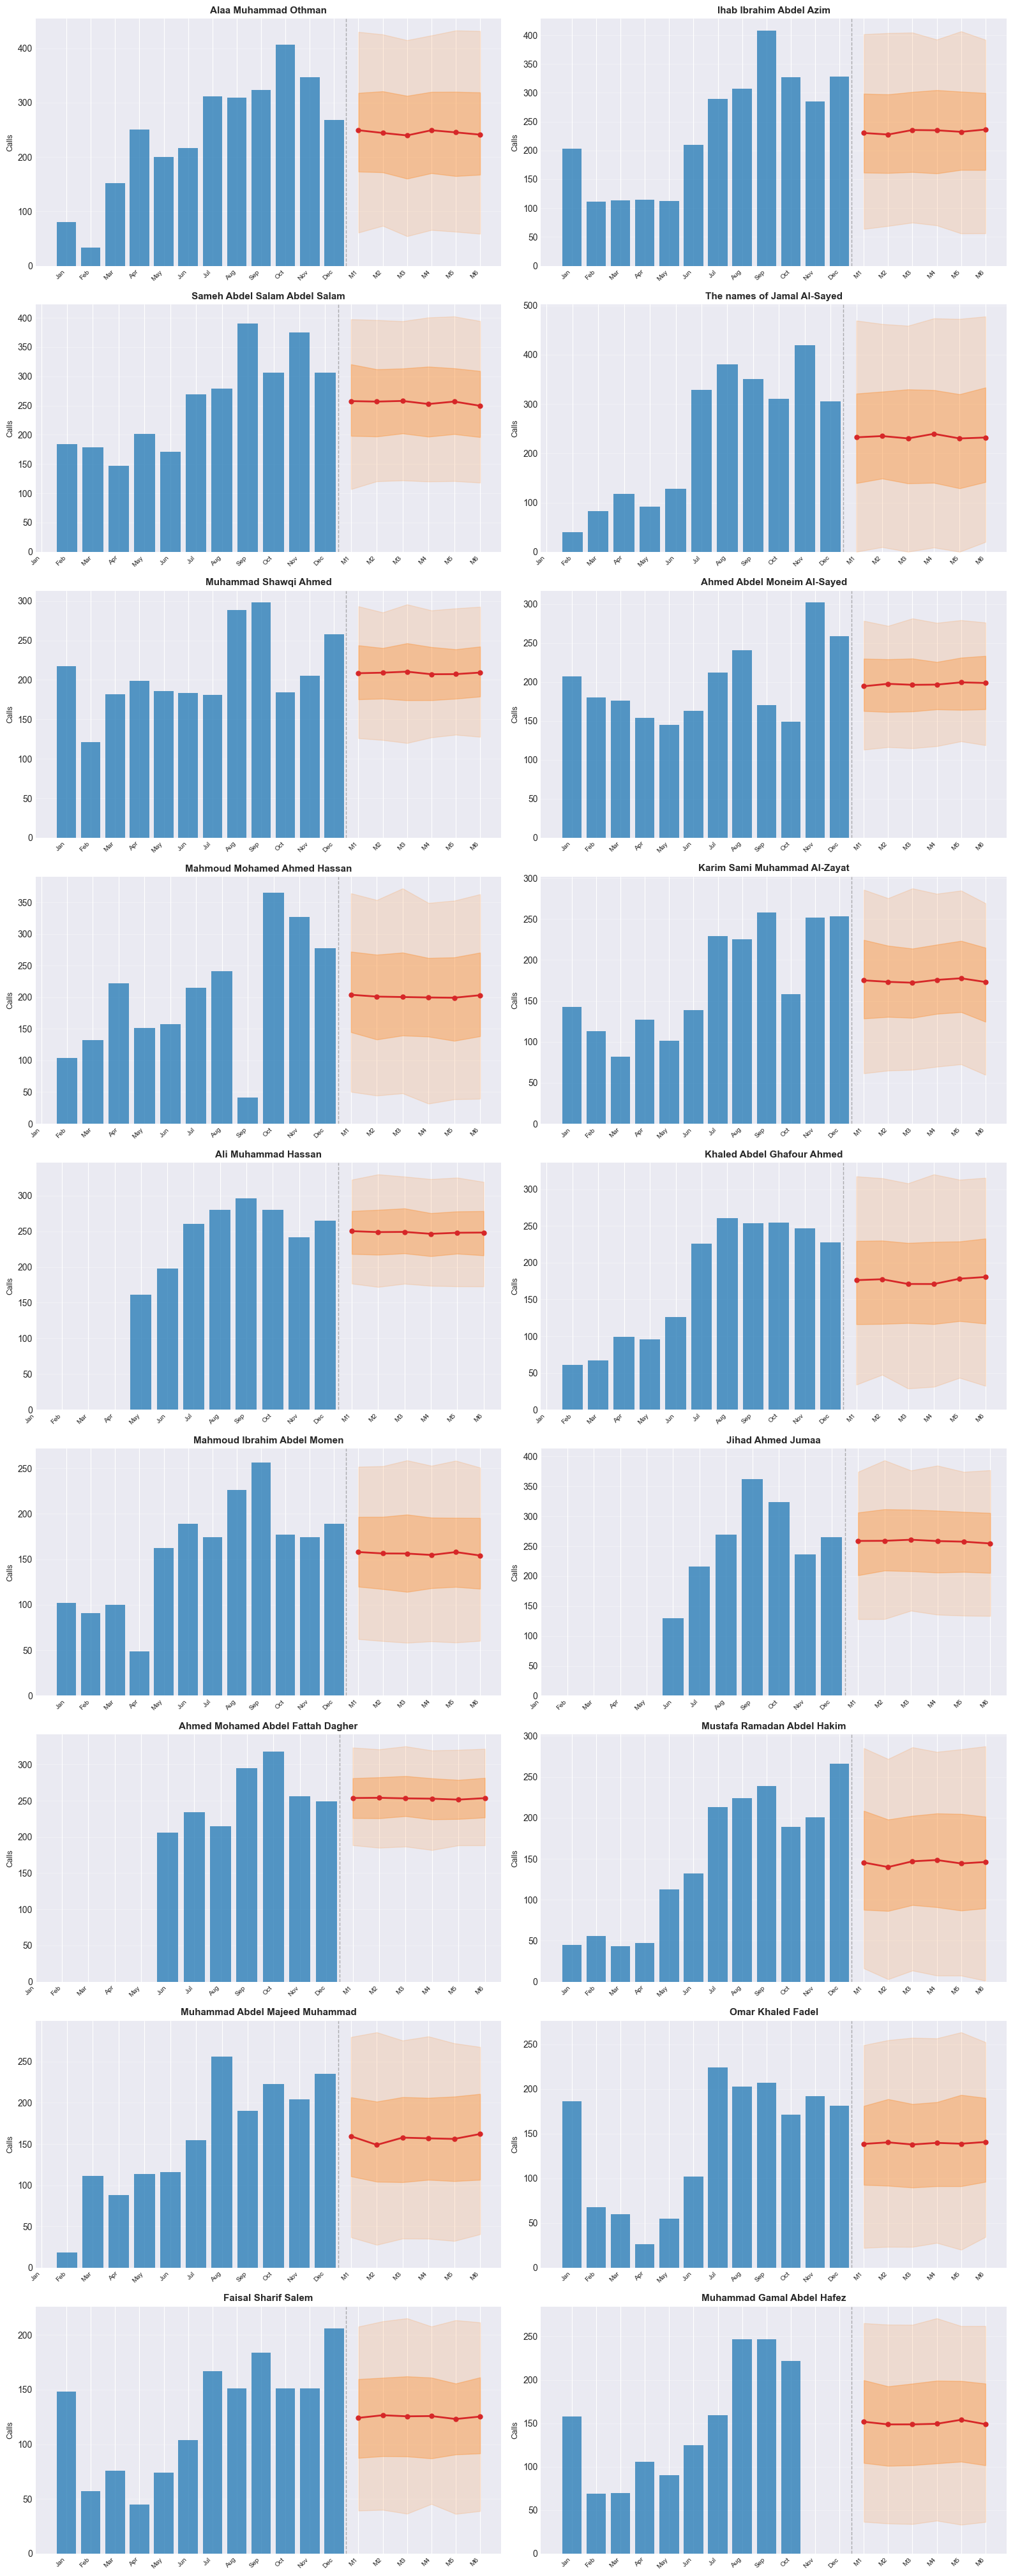

In [19]:
N_SIMULATIONS = 1000
N_FORECAST_MONTHS = 6
COLORS = {'primary':'#1f77b4','warning':'#ff7f0e','danger':'#d62728'}
month_labels_short = ['Jan','Feb','Mar','Apr','May','Jun',
                      'Jul','Aug','Sep','Oct','Nov','Dec']
forecast_labels = [f'M{i+1}' for i in range(N_FORECAST_MONTHS)]

emp_2025=working_data[working_data.index.year == 2025]

emp_monthly = emp_2025.groupby(['employee_en', 'month']).size().reset_index(name='calls')

top_employees = (
    emp_monthly.groupby('employee_en')['calls'].sum()
    .sort_values(ascending=False)
    .head(18)
    .index)

emp_forecasts = {}
for emp in top_employees:
    emp_data = emp_monthly[emp_monthly['employee_en'] == emp]['calls']
    if len(emp_data) < 2:
        continue

    emp_mean = emp_data.mean()
    emp_std  = emp_data.std()

    sims = np.random.normal(loc=emp_mean, scale=emp_std, size=(N_SIMULATIONS, N_FORECAST_MONTHS))
    sims = np.clip(sims, 0, None)

    emp_forecasts[emp] = {
        'mean':  emp_mean,
        'std':   emp_std,
        'p5':    np.percentile(sims, 5,  axis=0),
        'p25':   np.percentile(sims, 25, axis=0),
        'p50':   np.percentile(sims, 50, axis=0),
        'p75':   np.percentile(sims, 75, axis=0),
        'p95':   np.percentile(sims, 95, axis=0)
    }

print(f"Simulated {len(emp_forecasts)} employees for 2025")

n_employees = len(emp_forecasts)
n_cols = 2
n_rows = int(np.ceil(n_employees / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4.5))
axes = axes.flatten() if n_employees > 1 else [axes]

for idx, (emp, forecast) in enumerate(emp_forecasts.items()):
    ax = axes[idx]
    hist = emp_monthly[emp_monthly['employee_en'] == emp].sort_values('month')
    hist_x = hist['month'].values - 1
    hist_y = hist['calls'].values
    ax.bar(hist_x, hist_y, color=COLORS['primary'], alpha=0.75, zorder=3)

    fore_x = np.arange(12, 12 + N_FORECAST_MONTHS)
    ax.fill_between(fore_x, forecast['p5'],  forecast['p95'], color=COLORS['warning'], alpha=0.15)
    ax.fill_between(fore_x, forecast['p25'], forecast['p75'], color=COLORS['warning'], alpha=0.30)
    ax.plot(fore_x, forecast['p50'], color=COLORS['danger'], marker='o', linewidth=2, markersize=5, zorder=4)
    ax.axvline(x=11.5, color='gray', linestyle='--', linewidth=1, alpha=0.6)

    all_x = list(range(12)) + list(range(12, 12 + N_FORECAST_MONTHS))
    all_labels = month_labels_short + forecast_labels
    ax.set_xticks(all_x)
    ax.set_xticklabels(all_labels, rotation=45, ha='right', fontsize=7.5)
    ax.set_title(emp, fontsize=11, fontweight='bold')
    ax.set_ylabel('Calls', fontsize=9)
    ax.grid(axis='y', alpha=0.3)

for i in range(len(emp_forecasts), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Recommendations
### Immediate Actions (This Week)
* Start a marketing campaign immediately ensuring that hotline works during weekends
* Increase staffing during peak hours
* Add 2 agents during identified peak window
* Expected impact: Reduce wait times by ~30%
* Prioritize top complaint type
* Allocate dedicated team for most common complaint category
* Create fast-track resolution process

### Short-Term (1–3 Months)
* Balance employee workload
* Redistribute calls between high performers and low ones
* Implement round-robin assignment during peak hours
* Track weekly to identify bottlenecks of complaint resolution

### Long-Term (3–12 Months)

* Predictive staffing model
* Use historical volume patterns to forecast future demand
* Automate shift scheduling based on predicted call volume
* Complaint automation
* For most common, simple complaint types: explore chatbot or automated FAQ routing
* Reserve human agents for complex or sensitive cases
---